In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('train.csv',encoding='unicode_escape')
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [5]:
df.describe()

,Population -2020,Land Area (Km²),Density (P/Km²)
count,2.748100e+04,2.748100e+04,27481.000000
mean,4.018497e+07,6.621730e+05,357.686583
std,1.504946e+08,1.807425e+06,2013.750702
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [6]:
df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [7]:
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')

In [8]:
df.dropna(inplace=True)
df.isna().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [9]:
text_df=df.drop(['textID', 'selected_text', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],axis=1)
text_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [10]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


In [11]:
text_df.dropna(inplace=True)
text_df.isna().sum()

text         0
sentiment    0
dtype: int64

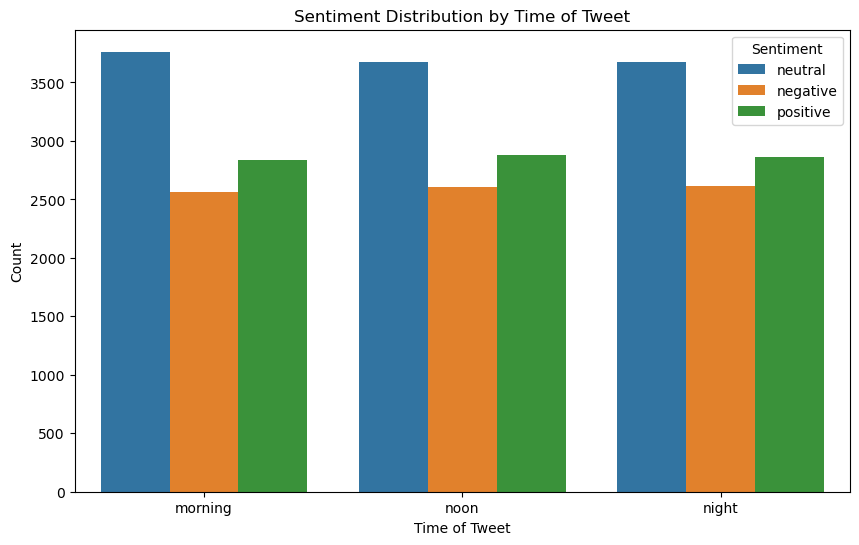

In [12]:
# Plotting figure of Time of Tweet vs Sentiment
df = df[['Time of Tweet','sentiment']]
plt.figure(figsize=(10, 6))
sns.countplot(x='Time of Tweet', hue='sentiment', data=df)
plt.title('Sentiment Distribution by Time of Tweet')
plt.xlabel('Time of Tweet')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

In [94]:
# Plotting
plt.figure(figsize=(12,6))
sns.countplot(x='Country', hue='sentiment', data=df, order=df['Country'].value_counts().iloc[:5].index)
plt.title('Top 5 Countries by Sentiment Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

KeyError: 'Country'

<Figure size 1200x600 with 0 Axes>

In [95]:
df = df[['Age of User','sentiment']]

# Create a cross-tabulation
age_sentiment = pd.crosstab(df['Age of User'], df['sentiment'])

# Plotting Age vs Sentiment
age_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Age of User')
plt.xlabel('Age of User')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

KeyError: "['Age of User'] not in index"

In [17]:
def text_processing(text):
    text=text.lower()
    text=re.sub(r"http\s+|www\s+https\s+", '', text, flags= re.MULTILINE)
    text=re.sub(r"\@w+|\#",'',text)
    text=re.sub(r"[^\w\s]",'',text)
    text=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text_tokens=word_tokenize(text)
    filtered_text=[w for w in text_tokens if not w in stopwords]
    return " ".join(filtered_text)

In [18]:
text_df.text= text_df['text'].apply(text_processing)

In [19]:
stemmer=PorterStemmer()
def stemming(data):
    text=[stemmer.stem(word) for word in data]
    return data

In [20]:
text_df['text']=text_df['text'].apply(lambda x :stemming(x))

In [21]:
text_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,boss bullying,negative
3,interview leave alone,negative
4,sons couldnt put releases already bought,negative


In [22]:
text_df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

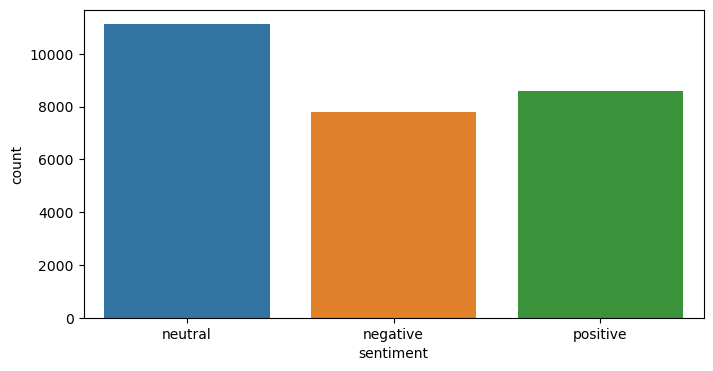

In [23]:
fig=plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

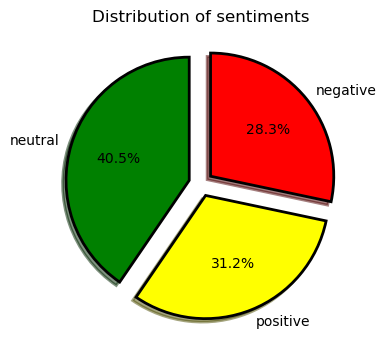

In [24]:
fig=plt.figure(figsize=(8,4))
colors=('green','yellow','red')
wp={'linewidth':2,'edgecolor':'black'}
tags=text_df['sentiment'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie',autopct='%1.1f%%',shadow=True,colors=colors,startangle=90,wedgeprops=wp,explode=explode,label='')
plt.title('Distribution of sentiments')

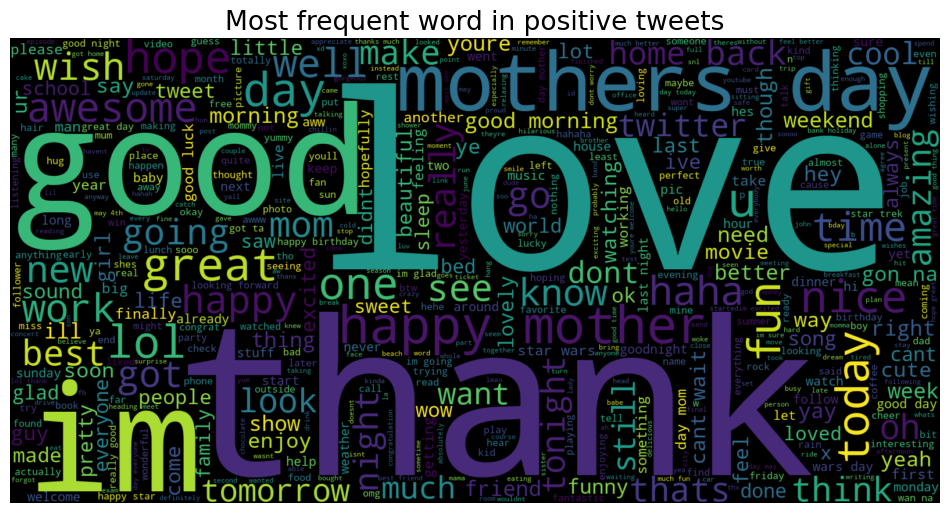

In [41]:
pos_tweet=text_df[text_df.sentiment == 'positive']
text=' '.join([word for word in pos_tweet['text']])
plt.figure(figsize=(12,8),facecolor='None')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent word in positive tweets',fontsize=19)
plt.show()

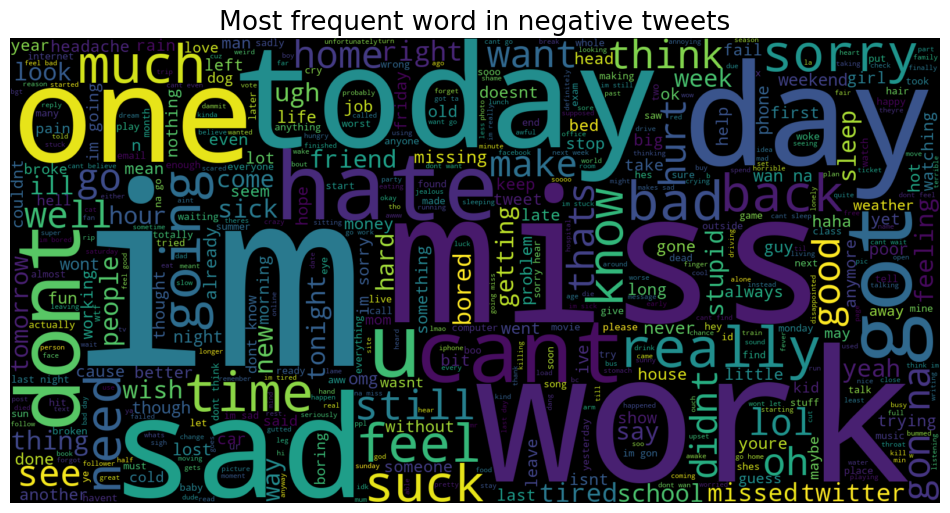

In [42]:
pos_tweet=text_df[text_df.sentiment == 'negative']
text=' '.join([word for word in pos_tweet['text']])
plt.figure(figsize=(12,8),facecolor='None')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent word in negative tweets',fontsize=19)
plt.show()

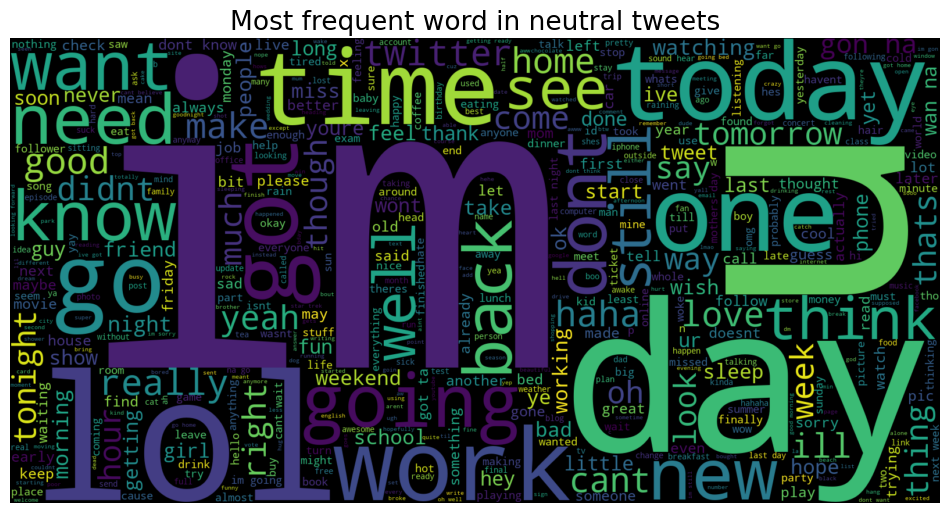

In [44]:
pos_tweet=text_df[text_df.sentiment == 'neutral']
text=' '.join([word for word in pos_tweet['text']])
plt.figure(figsize=(12,8),facecolor='None')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent word in neutral tweets',fontsize=19)
plt.show()

In [25]:
from collections import Counter
cnt = Counter()
for text in text_df['text']:
    for word in text.split():
        cnt[word] += 1

# Find most common 10 words from the Pandas dataframe
cnt.most_common(10)

[('im', 3024),
 ('day', 2044),
 ('good', 1550),
 ('get', 1426),
 ('like', 1346),
 ('go', 1267),
 ('got', 1226),
 ('dont', 1200),
 ('love', 1123),
 ('work', 1113)]

In [26]:
vectorizer=CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])


In [27]:
feature_names=vectorizer.get_feature_names_out()
print("Number of feature: {}\n".format(len(feature_names)))
print("First 20 features: \n {}".format(feature_names[:30]))

Number of feature: 162280

First 20 features: 
 ['00' '00 graduated' '000' '000 dunno' '000 well' '0003' '0003 im' '007'
 '007 dont' '007 tried' '01' '01 final' '01 mm' '01 winter' '01xx'
 '01xx dont' '024' '024 wire' '03' '03 hell' '03 scoreless' '04'
 '04 would' '0405' '0405 good' '0407' '0407 place' '04071991'
 '04071991 haaa' '0430']


In [28]:
x=text_df['text']
y=text_df['sentiment']
x=vectorizer.transform(x)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [30]:
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
logreg_pred=logreg.predict(x_test)
log_acc=accuracy_score(logreg_pred,y_test)

In [31]:
print("test_accuracy: {: 2f}%".format(log_acc*100))

test_accuracy:  68.316351%


In [33]:
print(confusion_matrix(y_test,logreg_pred))
print('\n')
print(classification_report(y_test,logreg_pred))

[[1307  898  151]
 [ 434 2496  413]
 [  81  635 1829]]


              precision    recall  f1-score   support

    negative       0.72      0.55      0.63      2356
     neutral       0.62      0.75      0.68      3343
    positive       0.76      0.72      0.74      2545

    accuracy                           0.68      8244
   macro avg       0.70      0.67      0.68      8244
weighted avg       0.69      0.68      0.68      8244



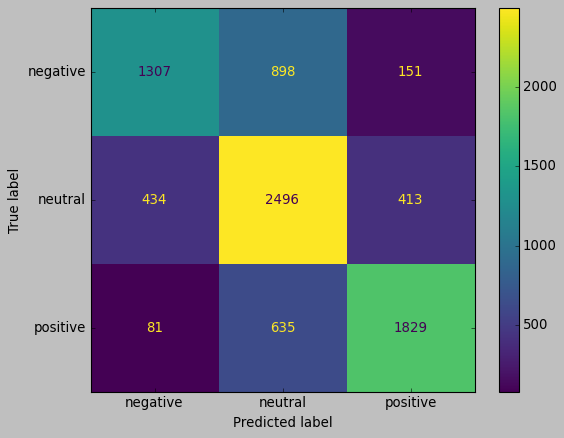

In [53]:
style.use('classic')
cm=confusion_matrix(y_test,logreg_pred,labels=logreg.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid={'C':[0.001,0.01,0.1,1,10,100]}
grid=GridSearchCV(LogisticRegression(),param_grid)
grid.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [46]:
print('Best parameter: ',grid.best_params_)

Best parameter:  {'C': 1}


In [47]:
y_pred=grid.predict(x_test)

In [48]:
log_reg_acc=accuracy_score(y_pred,y_test)
print("Test accuracy : {: 2f}%".format(log_reg_acc*100))

Test accuracy :  68.316351%


In [49]:
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[1307  898  151]
 [ 434 2496  413]
 [  81  635 1829]]


              precision    recall  f1-score   support

    negative       0.72      0.55      0.63      2356
     neutral       0.62      0.75      0.68      3343
    positive       0.76      0.72      0.74      2545

    accuracy                           0.68      8244
   macro avg       0.70      0.67      0.68      8244
weighted avg       0.69      0.68      0.68      8244



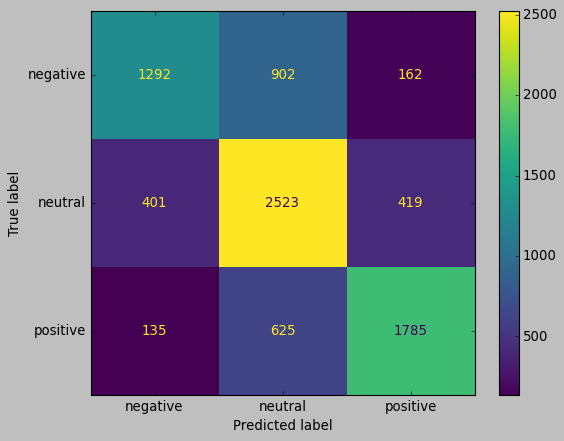

In [96]:
style.use('classic')
cm=confusion_matrix(y_test,y_pred,labels=logreg.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()

In [123]:
classifier = LogisticRegression()
y_score = classifier.fit(x_train, y_train).predict_proba(x_test)

In [124]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(8244, 3)

In [125]:
class_of_interest = "positive"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

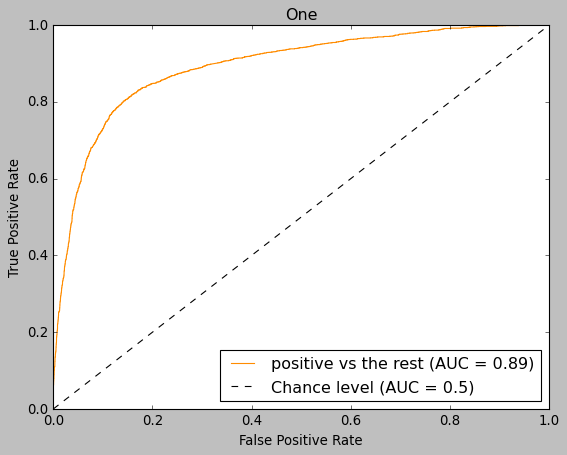

In [126]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One",
)

In [128]:
from itertools import combinations

pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

[('negative', 'neutral'), ('negative', 'positive'), ('neutral', 'positive')]


In [133]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.84


In [137]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.84


In [51]:
from sklearn.svm import LinearSVC

In [52]:
SVCmodel=LinearSVC()
SVCmodel.fit(x_train,y_train)

LinearSVC()

In [53]:
svc_pred=SVCmodel.predict(x_test)
svc_acc=accuracy_score(svc_pred,y_test)
svc_acc

0.6812227074235808

In [54]:
print(confusion_matrix(y_test,svc_pred))
print('\n')
print(classification_report(y_test,svc_pred))

[[1363  812  181]
 [ 502 2401  440]
 [  97  596 1852]]


              precision    recall  f1-score   support

    negative       0.69      0.58      0.63      2356
     neutral       0.63      0.72      0.67      3343
    positive       0.75      0.73      0.74      2545

    accuracy                           0.68      8244
   macro avg       0.69      0.67      0.68      8244
weighted avg       0.69      0.68      0.68      8244



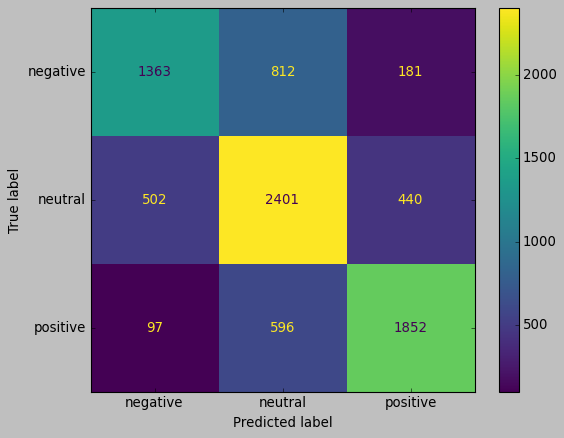

In [98]:
style.use('classic')
cm=confusion_matrix(y_test,svc_pred,labels=logreg.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVCmodel.classes_)
disp.plot()

In [134]:
n_classes = len(np.unique(y))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


In [138]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


Macro-averaged One-vs-One ROC AUC score:
0.84


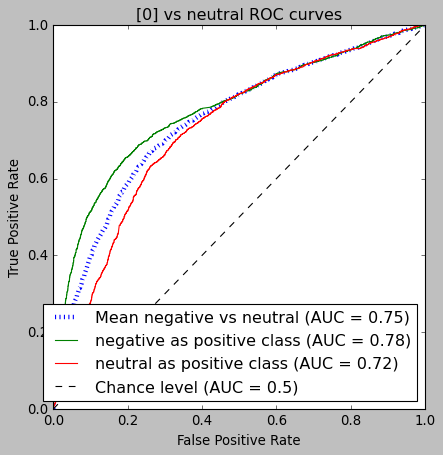

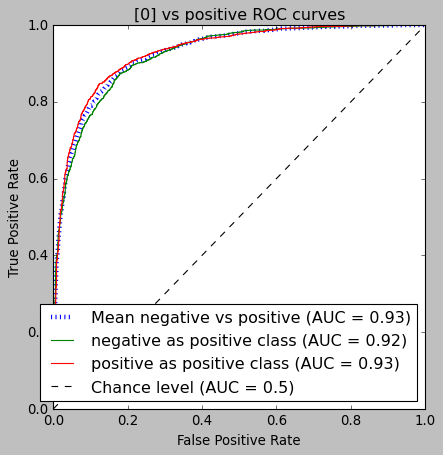

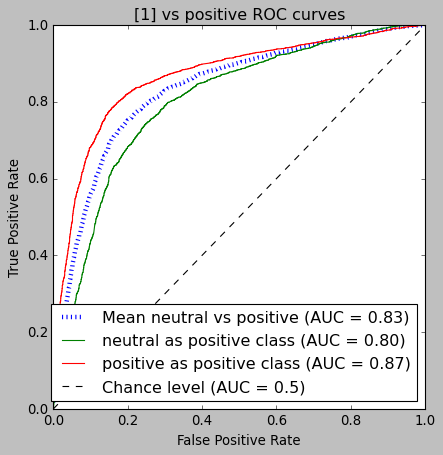

In [143]:
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):
    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
        plot_chance_level=True,
    )
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{[idx_a]} vs {label_b} ROC curves",
    )

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

In [91]:
from sklearn.tree import DecisionTreeClassifier

for i in range(3,20):
    DTmodel = DecisionTreeClassifier(max_depth=i)
    DTmodel.fit(x_train,y_train)
    print(i, DTmodel.score(x_test,y_test))

3 0.4810771470160116
4 0.49696749150897623
5 0.5065502183406113
6 0.5168607472100922
7 0.5240174672489083
8 0.5338427947598253
9 0.5378457059679768
10 0.5454876273653566
11 0.5500970402717128
12 0.5578602620087336
13 0.5646530810286269
14 0.5699902959728287
15 0.5752062105773896
16 0.5789665211062591
17 0.5828481319747695
18 0.5874575448811257
19 0.5896409509946627


In [100]:
DTpred=DTmodel.predict(x_test)
DT_acc=accuracy_score(DTpred,y_test)
DT_acc

0.5896409509946627

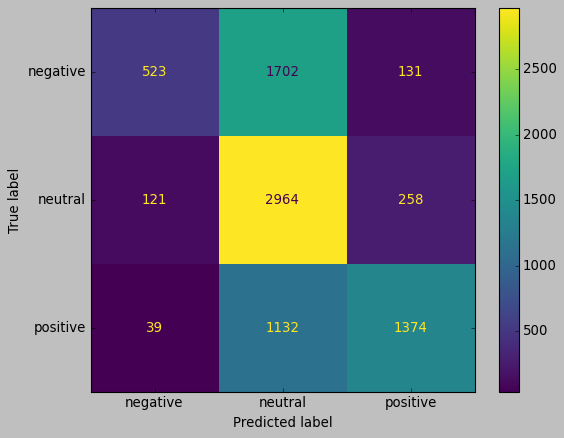

In [101]:
style.use('classic')
cm=confusion_matrix(y_test,DTpred,labels=logreg.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=DTmodel.classes_)
disp.plot()

In [56]:
from sklearn.neighbors import KNeighborsClassifier

KNmodel = KNeighborsClassifier()
KNmodel.fit(x_train,y_train)

KNeighborsClassifier()

In [57]:
KNmodel.score(x_test,y_test)

0.5362688015526443

In [87]:
kn_pred=KNmodel.predict(x_test)
kn_acc=accuracy_score(kn_pred,y_test)
kn_acc

0.5362688015526443

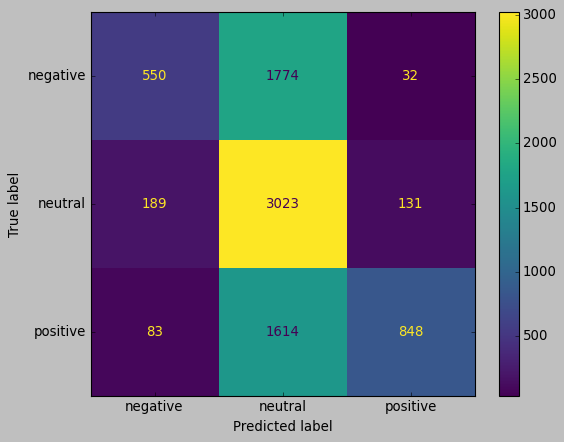

In [102]:
style.use('classic')
cm=confusion_matrix(y_test,kn_pred,labels=logreg.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=KNmodel.classes_)
disp.plot()

In [58]:
from sklearn.ensemble import RandomForestClassifier

Rfmodel = RandomForestClassifier(n_estimators=50, max_features=10, max_depth=5)
Rfmodel.fit(x_train,y_train)
Rfmodel.score(x_test,y_test)

0.4055070354196992

In [89]:
rf_pred=Rfmodel.predict(x_test)
rf_acc=accuracy_score(kn_pred,y_test)
rf_acc

0.5362688015526443

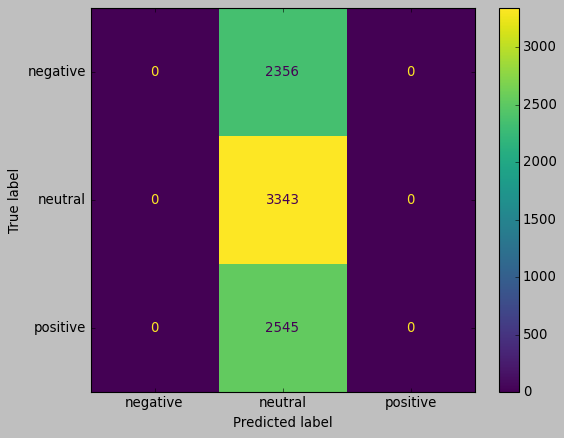

In [103]:
style.use('classic')
cm=confusion_matrix(y_test,rf_pred,labels=Rfmodel.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization,RNN
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.optimizers import Adam


In [60]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_df['text'])
sequences = tokenizer.texts_to_sequences(text_df['text'])

In [61]:
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post')

In [62]:
labels = pd.get_dummies(text_df['sentiment']).values

In [63]:
xtrian,xtest,ytrain,ytest = train_test_split(padded_sequences, labels, test_size = 0.1)

In [64]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
max_length = 32


In [65]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
max_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(32, return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(64))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [66]:
model.fit(xtrian, ytrain, epochs=5, validation_data=(xtest, ytest))

Epoch 1/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 98s 113ms/step - accuracy: 0.5415 - loss: 0.9484 - val_accuracy: 0.6721 - val_loss: 0.7932
Epoch 2/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.7864 - loss: 0.5466 - val_accuracy: 0.6947 - val_loss: 0.7417
Epoch 3/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 80s 104ms/step - accuracy: 0.8689 - loss: 0.3518 - val_accuracy: 0.6881 - val_loss: 0.8679
Epoch 4/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - accuracy: 0.9163 - loss: 0.2400 - val_accuracy: 0.6794 - val_loss: 0.9149
Epoch 5/5
773/773 ━━━━━━━━━━━━━━━━━━━━ 93s 120ms/step - accuracy: 0.9369 - loss: 0.1862 - val_accuracy: 0.6565 - val_loss: 1.3247


In [67]:
loss, accuracy = model.evaluate(xtest, ytest)
print("Test Accuracy:", accuracy)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6572 - loss: 1.3537
Test Accuracy: 0.6564774513244629


In [104]:
print("test_accuracy logistic regression: {: 2f}%".format(log_acc*100))
print("test_accuracy SVC: {: 2f}%".format(svc_acc*100))
print("test_accuracy Knearest: {: 2f}%".format(kn_acc*100))
print("test_accuracy Randomforest: {: 2f}%".format(rf_acc*100))
print("test_accuracy LSTM: {: 2f}%".format(accuracy*100))

test_accuracy logistic regression:  68.316351%
test_accuracy SVC:  68.122271%
test_accuracy Knearest:  53.626880%
test_accuracy Randomforest:  53.626880%
test_accuracy LSTM:  65.647745%


In [116]:
from sklearn.metrics import f1_score
logreg_f1=f1_score(y_test, logreg_pred, average=None)
SVC_f1=f1_score(y_test, svc_pred, average=None)
DT_f1=f1_score(y_test, DTpred, average=None)
kn_f1=f1_score(y_test, kn_pred, average=None)
randomforest_f1=f1_score(y_test, rf_pred, average=None)

print('f1 Score logistic regression: ',logreg_f1)
print('f1 Score SVC : ',SVC_f1)
print('f1 Score Decision tree: ',DT_f1)
print('f1 Score Knearest: ',kn_f1)
print('f1 Score Random forest regression: ',randomforest_f1)


f1 Score logistic regression:  [0.62565821 0.67715681 0.74078574]
f1 Score SVC :  [0.63131079 0.67142058 0.73814269]
f1 Score Decision tree:  [0.34419217 0.64850673 0.63788301]
f1 Score Knearest:  [0.34612964 0.61984827 0.47694038]
f1 Score Random forest regression:  [0.         0.57702598 0.        ]


In [106]:
def predict_sentiment(input_text, tokenizer, model, max_length):
    # Preprocess the input text
    input_sequence = tokenizer.texts_to_sequences([input_text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Get the prediction
    prediction = model.predict(padded_input_sequence)

    # Convert the prediction to sentiment label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    predicted_label_index = np.argmax(prediction)
    predicted_sentiment = sentiment_labels[predicted_label_index]

    return predicted_sentiment

In [107]:
positive_rows = text_df[text_df['sentiment'] == 'negative']
print(positive_rows[['text']].head(5))

                                        text
1                    sooo sad miss san diego
2                              boss bullying
3                      interview leave alone
4   sons couldnt put releases already bought
12       sharpie running dangerously low ink


In [108]:
input_text = "This is such a bad day"
predicted_sentiment = predict_sentiment(input_text, tokenizer, model, max_length)
print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Sentiment: Negative


In [109]:
import pickle 
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)